#Linear Kalman Filter Example

###Introduction

This notebook is designed to demonstrate how to use the StateSpace.jl package to execute the Kalman filter for a linear State Space model. The example that has been used here closely follows the one given on "Greg Czerniak's Website". Namely the voltage example on [this page.](http://greg.czerniak.info/guides/kalman1/)   

For those of you that do not need/want the explanation of the model and the code, you can skip right to the end of this notebook where the entire section of code required to run this example is given.

###The Problem
The problem that we will consider here is that of predicting the true value of the voltage given some noisy measurements from a voltmeter. We also are armed with the knowledge that the true voltage remains constant.   

#####Process Model
We will define our state transistion as

$$x_i = x_{i-1} + v_i$$   

where $x_i$ is the current state, i.e. the current voltage, $x_{i-1}$ is the previous state (voltage) and $v_i$ is the process noise error.

#####Observation Model
We will assume that our voltmeter gives us the voltage directly. This means the observation equation is

$$y_i = x_i + w_i$$

where $y_i$ is the current observation, i.e. measured voltage, and $w_i$ is the observation error.

###Setting up the problem
First we'll import the modules that we need

In [6]:
using StateSpace
using Distributions
using DataFrames
using Gadfly
using Colors

###### Generate noisy observations
In this section we need to generate the noisy observations. Let's first define a true voltage value.

In [7]:
true_voltage = 1.25

1.25

Now we need to set the noise level for the observations. We'll do this by setting the variance.

In [8]:
measurement_noise_variance = 0.1

0.1

Now we can simulate a set of noisy measurements. We'll do this by adding zero mean Gaussian noise with the variance that we just specified above.

In [9]:
number_of_observations = 60 
observations = randn(number_of_observations) * sqrt(measurement_noise_variance) + true_voltage
observations = observations'

1x60 Array{Float64,2}:
 0.867216  0.94188  0.519849  0.699067  …  0.93253  1.55718  1.38088  1.10902

Note that we had to transpose the observations matrix because by default a 1-dimensional array in Julia is a column array. In StateSpace.jl a single column is considered as a single observation (for the case where we have multiple elements that are considered a single observation). This means that the second dimension is interpreted as separate observations.   

Let's plot the observations to see what we are dealing with.

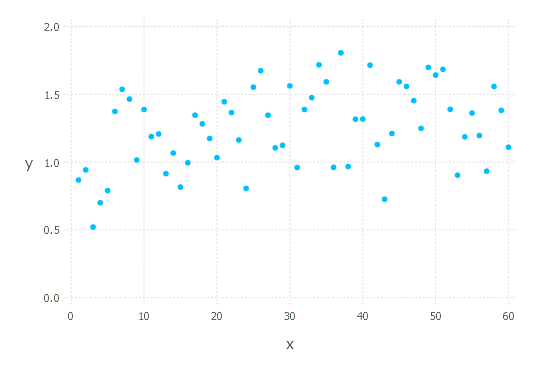

In [10]:
plt = plot(x=1:60, y=observations, Geom.point)

#####Define Kalman Filter Parameters
We can define the process and observation parameters according to the model defined above. Since the process doesn't change, the process parameter is equal to 1. Also since the voltage is observed directly, the observation parameter is also equal to 1.
Since we are very sure that the voltage is constant we can set the process variance to a small value. We've also already set the measurement variance previously. Therefore we have the following parameters:

In [11]:
process_parameter = 1.0
process_variance = 0.00001
observation_parameter = 1.0
observation_variance = measurement_noise_variance

0.1

We can now create the instance of the Linear State Space Model

In [12]:
linSSM = LinearGaussianSSM(process_parameter, process_variance, observation_parameter, observation_variance)

StateSpace.LinearGaussianSSM{Float64}(1x1 Array{Float64,2}:
 1.0,1x1 Array{Float64,2}:
 1.0e-5,1x1 Array{Float64,2}:
 1.0,1x1 Array{Float64,2}:
 0.1)

#####Initial Guess
Let's create an initial guess for the voltage. We'll assume that we're not too sure and we'll make a guess that differs from the true value with some variance

In [13]:
initial_guess = MvNormal([3.0], [1.0])

DiagNormal(
dim: 1
μ: [3.0]
Σ: 1x1 Array{Float64,2}:
 1.0
)


#####Perform Kalman Filter Algorithm
Now we have all of the parameters:
1. noisy observations
2. process (transition) and observation (emission) model paramaters
3. initial guess of state   

We can use the Kalman Filter to predict the true underlying state (voltage).

In [14]:
filtered_state = filter(linSSM, observations, initial_guess)

SmoothedState{Float64}


61 estimates of 1-D process from 1-D observations
Log-likelihood: 89.37290609952812


And there you have it. You have just used the StateSpace.jl package to obtain a filtered estimate of the state of the State Space system.

#####Plotting the result
There are several plotting packages available to this and you can find out about them [here](https://en.wikibooks.org/wiki/Introducing_Julia/Plotting) and pick your favourite one. We will demonstrate how to plot the results using Gadfly.

First we extract the filtered state along with their corresponding $2\sigma$ values (the give the area that we would expect the true value to lie with 95% confidence).

In [15]:
x_data = 1:number_of_observations
state_array = Vector{Float64}(number_of_observations+1)
confidence_array = Vector{Float64}(number_of_observations+1)
for i in 1:number_of_observations+1
    current_state = filtered_state.state[i]
    state_array[i] = current_state.μ[1]
    if i != 1
        confidence_array[i] = 2*sqrt(current_state.Σ.mat[1])
    else
        confidence_array[i] = 2*sqrt(current_state.Σ.diag[1])
    end
end

Next we will create a dataframe. This is simply so the syntax is simple for plotting the ribbon digram which will represent the state along with the confidence interval

In [16]:
df_fs = DataFrame(
    x = [0;x_data],
    y = state_array,
    ymin = state_array - confidence_array,
    ymax = state_array + confidence_array,
    f = "Filtered values"
    )

,x,y,ymin,ymax,f
1,0,3.0,1.0,5.0,Filtered values
2,1,1.0611037286205813,0.45808076536638553,1.664126691874777,Filtered values
3,2,1.0043272434764778,0.5678787864387553,1.4407757005142003,Filtered values
4,3,0.8480157101346791,0.4887724921158011,1.207258928153557,Filtered values
5,4,0.8116731388775696,0.4992675786216292,1.12407869913351,Filtered values
6,5,0.807189150166465,0.5270451691959738,1.087333131136956,Filtered values
7,6,0.8999378498054265,0.6437422910175581,1.1561334085932948,Filtered values
8,7,0.989622311169391,0.7521068521282737,1.2271377702105084,Filtered values
9,8,1.0483116723177255,0.8258898085494348,1.2707335360860161,Filtered values
10,9,1.0446087784073468,0.8347087112635011,1.2545088455511924,Filtered values


Next we will create separate colours for the observations and the true value. Here we will generate the default distinguishable colors used by Gadfly.

In [17]:
n = 3 #We will require 3 different colors
getColors = distinguishable_colors(n, Color[LCHab(70, 60, 240)],
                                   transform=c -> deuteranopic(c, 0.5),
                                   lchoices=Float64[65, 70, 75, 80],
                                   cchoices=Float64[0, 50, 60, 70],
                                   hchoices=linspace(0, 330, 24))

Finally we will plot the results

In [18]:
filtered_state_plot = plot(
    layer(x=x_data, y=filtered_state.observations, Geom.point, Theme(default_color=getColors[2])),
    layer(x=[0;x_data], y=ones(number_of_observations+1)*true_voltage, Geom.line, Theme(default_color=getColors[3])),
    layer(df_fs, x=:x, y=:y, ymin=:ymin, ymax=:ymax, Geom.line, Geom.ribbon),
    Guide.xlabel("Measurement Number"), Guide.ylabel("Voltage (Volts)"),
    Guide.manual_color_key("Colour Key",["Filtered Estimate", "Measurements","True Value "],[getColors[1],getColors[2],getColors[3]]),
    Guide.title("Linear Kalman Filter Example")
    )
display(filtered_state_plot)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Measurement Number 
 
 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 130 
 -60 
 -58 
 -56 
 -54 
 -52 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 72 
 74 
 76 
 78 
 80 
 82 
 84 
 86 
 88 
 90 
 92 
 94 
 96 
 98 
 100 
 102 
 104 
 106 
 108 
 110 
 112 
 114 
 116 
 118 
 120 
 -100 
 0 
 100 
 200 
 -60 
 -55 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 75 
 80 
 85 
 90 
 95 
 100 
 105 
 110 
 115 
 120 
 
 
 
 Filtered Estimate 
 Measurements 
 True Value 
 
 
 
 
 
 
 
 Colour Key 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M110.01,63.73 L 108.48 63.7 106.95 63.74 105.42 63.82 103.89 63.75 102.36 63.74 100.84 63.78 99.31 63.77 97.78 63.68 96.25 63.72 94.72 63.85 93.19 63.97 91.66 64.11 90.13 64.13 88.61 64.2 87.08 64.32 85.55 64.44 84.02 64.46 82.49 64.31 80.96 64.3 79.43 64.48 77.9 64.53 76.38 64.58 74.85 64.51 73.32 64.74 71.79 64.67 70.26 64.84 68.73 65.07 67.2 65.22 65.68 65.33 64.15 65.27 62.62 65.47 61.09 65.48 59.56 65.49 58.03 65.61 56.5 65.92 54.97 66.18 53.45 66.05 51.92 66.11 50.39 66.3 48.86 66.56 47.33 66.57 45.8 66.67 44.27 66.87 42.74 67.15 41.22 67.16 39.69 67 38.16 67.06 36.63 66.97 35.1 67.2 33.57 67.44 32.04 68.01 30.51 68.13 28.99 69.07 27.46 70.46 25.93 71.96 24.4 72.31 22.87 72.45 21.34 71.43 19.81 72.84 18.28 65.89 18.28 14.61 19.81 57.38 21.34 60.24 22.87 63.24 24.4 64.3 25.93 64.77 27.46 63.89 28.99 62.98 30.51 62.42 32.04 62.63 33.57 62.33 35.1 62.32 36.63 62.3 38.16 62.57 39.69 62.67 41.22 62.97 42.74 63.09 44.27 62.93 45.8 62.84 47.33 62.83 48.86 62.92 50.39 62.74 51.92 62.63 53.45 62.64 54.97 62.85 56.5 62.65 58.03 62.41 59.56 62.34 61.09 62.39 62.62 62.43 64.15 62.27 65.68 62.38 67.2 62.31 68.73 62.21 70.26 62.02 71.79 61.88 73.32 61.99 74.85 61.79 76.38 61.89 77.9 61.87 79.43 61.85 80.96 61.7 82.49 61.74 84.02 61.91 85.55 61.93 87.08 61.83 88.61 61.74 90.13 61.68 91.66 61.69 93.19 61.57 94.72 61.47 96.25 61.36 97.78 61.34 99.31 61.44 100.84 61.47 102.36 61.45 103.89 61.48 105.42 61.56 106.95 61.5 108.48 61.47 110.01 61.52 z"/>
 
 
 <path fill="none" d="M18.28,40.25 L 19.81 65.11 21.34 65.84 22.87 67.84 24.4 68.31 25.93 68.37 27.46 67.18 28.99 66.03 30.51 65.27 32.04 65.32 33.57 64.89 35.1 64.76 36.63 64.63 38.16 64.82 39.69 64.83 41.22 65.06 42.74 65.12 44.27 64.9 45.8 64.76 47.33 64.7 48.86 64.74 50.39 64.52 51.92 64.37 53.45 64.34 54.97 64.52 56.5 64.28 58.03 64.01 59.56 63.91 61.09 63.94 62.62 63.95 64.15 63.77 65.68 63.86 67.2 63.76 68.73 63.64 70.26 63.43 71.79 63.28 73.32 63.37 74.85 63.15 76.38 63.24 77.9 63.2 79.43 63.16 80.96 63 82.49 63.03 84.02 63.19 85.55 63.19 87.08 63.07 88.61 62.97 90.13 62.91 91.66 62.9 93.19 62.77 94.72 62.66 96.25 62.54 97.78 62.51 99.31 62.6 100.84 62.62 102.36 62.6 103.89 62.61 105.42 62.69 106.95 62.62 108.48 62.59 110.01 62.62"/>
 
 
 <path fill="none" d="M18.28,62.69 L 19.81 62.69 21.34 62.69 22.87 62.69 24.4 62.69 25.93 62.69 27.46 62.69 28.99 62.69 30.51 62.69 32.04 62.69 33.57 62.69 35.1 62.69 36.63 62.69 38.16 62.69 39.69 62.69 41

###Smoothing

We can also perform smoothing on the filtered estimates to get a better estimate of the true underlying state (as they say, hindsight is 20/20). This can be performed once you have the filtered estimate like so:

In [19]:
smoothed_state = smooth(linSSM, filtered_state)

SmoothedState{Float64}


60 estimates of 1-D process from 1-D observations
Log-likelihood: 120.15074208037329


Now we can the results in the same way as above to visualize the smoothed result.

In [20]:
state_array = Vector{Float64}(number_of_observations)
confidence_array = Vector{Float64}(number_of_observations)
for i in x_data
    current_state = smoothed_state.state[i]
    state_array[i] = current_state.μ[1]
    confidence_array[i] = 2*sqrt(current_state.Σ.mat[1])
end
df_ss = DataFrame(
    x = x_data,
    y = state_array,
    ymin = state_array - confidence_array,
    ymax = state_array + confidence_array,
    f = "Filtered values"
    )

smoothed_state_plot = plot(
    layer(x=x_data, y=smoothed_state.observations, Geom.point, Theme(default_color=getColors[2])),
    layer(x=x_data, y=ones(number_of_observations)*true_voltage, Geom.line, Theme(default_color=getColors[3], line_width=3px)),
    layer(df_ss, x=:x, y=:y, ymin=:ymin, ymax=:ymax, Geom.line, Geom.ribbon, Theme(line_width=3px)),
    Guide.xlabel("Measurement Number"), Guide.ylabel("Voltage (Volts)"),
    Guide.manual_color_key("Colour Key",["Smoothed Estimate", "Measurements","True Value "],[getColors[1],getColors[2],getColors[3]]),
    Guide.title("Linear Kalman Smoother Example"), Theme(major_label_font_size=20px, key_label_font_size=20px)
    )
display(smoothed_state_plot)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Measurement Number 
 
 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 130 
 -60 
 -58 
 -56 
 -54 
 -52 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 72 
 74 
 76 
 78 
 80 
 82 
 84 
 86 
 88 
 90 
 92 
 94 
 96 
 98 
 100 
 102 
 104 
 106 
 108 
 110 
 112 
 114 
 116 
 118 
 120 
 -100 
 0 
 100 
 200 
 -60 
 -55 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 75 
 80 
 85 
 90 
 95 
 100 
 105 
 110 
 115 
 120 
 
 
 
 Smoothed Estimate 
 Measurements 
 True Value 
 
 
 
 
 
 
 
 Colour Key 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M85.35,41.46 L 84.3 41.46 83.24 41.45 82.18 41.45 81.12 41.44 80.07 41.43 79.01 41.43 77.95 41.42 76.9 41.42 75.84 41.41 74.78 41.41 73.73 41.41 72.67 41.41 71.61 41.41 70.56 41.41 69.5 41.41 68.44 41.41 67.39 41.41 66.33 41.41 65.27 41.42 64.22 41.42 63.16 41.42 62.1 41.42 61.05 41.43 59.99 41.43 58.93 41.44 57.88 41.45 56.82 41.45 55.76 41.46 54.71 41.47 53.65 41.48 52.59 41.49 51.53 41.5 50.48 41.5 49.42 41.51 48.36 41.53 47.31 41.54 46.25 41.55 45.19 41.56 44.14 41.57 43.08 41.58 42.02 41.59 40.97 41.61 39.91 41.62 38.85 41.63 37.8 41.64 36.74 41.65 35.68 41.66 34.63 41.67 33.57 41.68 32.51 41.69 31.46 41.7 30.4 41.71 29.34 41.72 28.29 41.74 27.23 41.75 26.17 41.76 25.11 41.77 24.06 41.77 23 41.78 23 36.46 24.06 36.47 25.11 36.48 26.17 36.48 27.23 36.48 28.29 36.49 29.34 36.48 30.4 36.48 31.46 36.48 32.51 36.48 33.57 36.48 34.63 36.48 35.68 36.48 36.74 36.48 37.8 36.48 38.85 36.47 39.91 36.47 40.97 36.46 42.02 36.46 43.08 36.45 44.14 36.44 45.19 36.44 46.25 36.43 47.31 36.42 48.36 36.42 49.42 36.41 50.48 36.4 51.53 36.39 52.59 36.38 53.65 36.38 54.71 36.37 55.76 36.36 56.82 36.35 57.88 36.34 58.93 36.33 59.99 36.33 61.05 36.32 62.1 36.31 63.16 36.31 64.22 36.3 65.27 36.29 66.33 36.29 67.39 36.28 68.44 36.27 69.5 36.26 70.56 36.26 71.61 36.25 72.67 36.24 73.73 36.23 74.78 36.23 75.84 36.22 76.9 36.21 77.95 36.21 79.01 36.21 80.07 36.2 81.12 36.2 82.18 36.19 83.24 36.18 84.3 36.18 85.35 36.17 z"/>
 
 
 <path fill="none" d="M23,39.12 L 24.06 39.12 25.11 39.12 26.17 39.12 27.23 39.12 28.29 39.11 29.34 39.1 30.4 39.1 31.46 39.09 32.51 39.09 33.57 39.08 34.63 39.08 35.68 39.07 36.74 39.07 37.8 39.06 38.85 39.05 39.91 39.04 40.97 39.03 42.02 39.03 43.08 39.02 44.14 39.01 45.19 39 46.25 38.99 47.31 38.98 48.36 38.97 49.42 38.96 50.48 38.95 51.53 38.94 52.59 38.94 53.65 38.93 54.71 38.92 55.76 38.91 56.82 38.9 57.88 38.89 58.93 38.89 59.99 38.88 61.05 38.87 62.1 38.87 63.16 38.86 64.22 38.86 65.27 38.85 66.33 38.85 67.39 38.85 68.44 38.84 69.5 38.84 70.56 38.83 71.61 38.83 72.67 38.82 73.73 38.82 74.78 38.82 75.84 38.82 76.9 38.82 77.95 38.82 79.01 38.82 80.07 38.82 81.12 38.82 82.18 38.82 83.24 38.82 84.3 38.82 85.35 38.82"/>
 
 
 <path fill="none" d="M23,38.98 L 24.06 38.98 25.11 38.98 26.17 38.98 27.23 38.98 28.29 38.98 29.34 38.98 30.4 38.98 31.46 38.98 32.51 38.98 33.57 38.98 34.63 38.98 35.68 38.98 36.74 38.98 37.8 38.98 38.85 38.98 39.91 38.98 40.97 38.98 42.02 38.98 43.08 38.98 44.14 38.98 45.19 38.98 46.25 38.98 47.

For those that would like to copy and paste the code. Here is the code in full:

In [1]:
using StateSpace
using Distributions
using DataFrames
using Gadfly
using Colors

#Generate noisy observations
true_voltage = 1.25
measurement_noise_variance = 0.1
number_of_observations = 60 
observations = randn(number_of_observations) * sqrt(measurement_noise_variance) + true_voltage
observations = observations'

#Define Filter parameters
process_parameter = 1.0
process_variance = 0.00001
observation_parameter = 1.0
observation_variance = measurement_noise_variance
linSSM = LinearGaussianSSM(process_parameter, process_variance, observation_parameter, observation_variance)

initial_guess = MvNormal([3.0], [1.0]) #Give initial guess parameters

filtered_state = filter(linSSM, observations, initial_guess) #Perform Kalman Filter
smoothed_state = smooth(linSSM, filtered_state) #Perform Kalman Smoother

#Plot the filter results
x_data = 1:number_of_observations
state_array = Vector{Float64}(number_of_observations+1)
confidence_array = Vector{Float64}(number_of_observations+1)
for i in 1:number_of_observations+1
    current_state = filtered_state.state[i]
    state_array[i] = current_state.μ[1]
    if i != 1
        confidence_array[i] = 2*sqrt(current_state.Σ.mat[1])
    else
        confidence_array[i] = 2*sqrt(current_state.Σ.diag[1])
    end
end
df_fs = DataFrame(
    x = [0;x_data],
    y = state_array,
    ymin = state_array - confidence_array,
    ymax = state_array + confidence_array,
    f = "Filtered values"
    )

n = 3
getColors = distinguishable_colors(n, Color[LCHab(70, 60, 240)],
                                   transform=c -> deuteranopic(c, 0.5),
                                   lchoices=Float64[65, 70, 75, 80],
                                   cchoices=Float64[0, 50, 60, 70],
                                   hchoices=linspace(0, 330, 24))
filtered_state_plot = plot(
    layer(x=x_data, y=filtered_state.observations, Geom.point, Theme(default_color=getColors[2])),
    layer(x=[0;x_data], y=ones(number_of_observations+1)*true_voltage, Geom.line, Theme(default_color=getColors[3])),
    layer(df_fs, x=:x, y=:y, ymin=:ymin, ymax=:ymax, Geom.line, Geom.ribbon),
    Guide.xlabel("Measurement Number"), Guide.ylabel("Voltage (Volts)"),
    Guide.manual_color_key("Colour Key",["Filtered Estimate", "Measurements","True Value "],[getColors[1],getColors[2],getColors[3]]),
    Guide.title("Linear Kalman Filter Example")
    )
display(filtered_state_plot)

#Plot the smoothed results
state_array = Vector{Float64}(number_of_observations)
confidence_array = Vector{Float64}(number_of_observations)
for i in x_data
    current_state = smoothed_state.state[i]
    state_array[i] = current_state.μ[1]
    confidence_array[i] = 2*sqrt(current_state.Σ.mat[1])
end
df_ss = DataFrame(
    x = x_data,
    y = state_array,
    ymin = state_array - confidence_array,
    ymax = state_array + confidence_array,
    f = "Filtered values"
    )

smoothed_state_plot = plot(
    layer(x=x_data, y=smoothed_state.observations, Geom.point, Theme(default_color=getColors[2])),
    layer(x=x_data, y=ones(number_of_observations)*true_voltage, Geom.line, Theme(default_color=getColors[3], line_width=3px)),
    layer(df_ss, x=:x, y=:y, ymin=:ymin, ymax=:ymax, Geom.line, Geom.ribbon, Theme(line_width=3px)),
    Guide.xlabel("Measurement Number"), Guide.ylabel("Voltage (Volts)"),
    Guide.manual_color_key("Colour Key",["Smoothed Estimate", "Measurements","True Value "],[getColors[1],getColors[2],getColors[3]]),
    Guide.title("Linear Kalman Smoother Example"), Theme(major_label_font_size=20px, key_label_font_size=20px)
    )
display(smoothed_state_plot)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Measurement Number 
 
 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 130 
 -60 
 -58 
 -56 
 -54 
 -52 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 72 
 74 
 76 
 78 
 80 
 82 
 84 
 86 
 88 
 90 
 92 
 94 
 96 
 98 
 100 
 102 
 104 
 106 
 108 
 110 
 112 
 114 
 116 
 118 
 120 
 -100 
 0 
 100 
 200 
 -60 
 -55 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 75 
 80 
 85 
 90 
 95 
 100 
 105 
 110 
 115 
 120 
 
 
 
 Filtered Estimate 
 Measurements 
 True Value 
 
 
 
 
 
 
 
 Colour Key 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M110.01,64.23 L 108.48 64.1 106.95 63.94 105.42 63.87 103.89 63.88 102.36 63.98 100.84 63.97 99.31 64.05 97.78 64.12 96.25 64.16 94.72 64.18 93.19 64.2 91.66 64.08 90.13 64.2 88.61 64.31 87.08 64.45 85.55 64.49 84.02 64.51 82.49 64.39 80.96 64.33 79.43 64.43 77.9 64.37 76.38 64.32 74.85 64.4 73.32 64.46 71.79 64.39 70.26 64.35 68.73 64.27 67.2 64.25 65.68 64.34 64.15 64.33 62.62 64.19 61.09 64.33 59.56 64.3 58.03 64.29 56.5 64.45 54.97 64.47 53.45 64.46 51.92 64.49 50.39 64.81 48.86 64.82 47.33 64.61 45.8 64.62 44.27 64.53 42.74 64.46 41.22 64.88 39.69 65.22 38.16 65.02 36.63 65.1 35.1 65.16 33.57 64.34 32.04 64.48 30.51 64.35 28.99 64.72 27.46 64.44 25.93 65.24 24.4 64.43 22.87 64.88 21.34 64.77 19.81 64.16 18.28 65.89 18.28 14.61 19.81 48.7 21.34 53.58 22.87 55.67 24.4 56.42 25.93 58.05 27.46 57.87 28.99 58.63 30.51 58.64 32.04 59.09 33.57 59.23 35.1 60.29 36.63 60.43 38.16 60.53 39.69 60.89 41.22 60.69 42.74 60.4 44.27 60.59 45.8 60.79 47.33 60.88 48.86 61.18 50.39 61.25 51.92 61.02 53.45 61.05 54.97 61.14 56.5 61.18 58.03 61.09 59.56 61.15 61.09 61.24 62.62 61.15 64.15 61.33 65.68 61.39 67.2 61.34 68.73 61.4 70.26 61.52 71.79 61.6 73.32 61.7 74.85 61.68 76.38 61.63 77.9 61.72 79.43 61.8 80.96 61.73 82.49 61.82 84.02 61.97 85.55 61.97 87.08 61.96 88.61 61.84 90.13 61.76 91.66 61.66 93.19 61.8 94.72 61.79 96.25 61.8 97.78 61.78 99.31 61.73 100.84 61.67 102.36 61.69 103.89 61.61 105.42 61.62 106.95 61.7 108.48 61.88 110.01 62.02 z"/>
 
 
 <path fill="none" d="M18.28,40.25 L 19.81 56.43 21.34 59.18 22.87 60.28 24.4 60.42 25.93 61.65 27.46 61.16 28.99 61.68 30.51 61.49 32.04 61.78 33.57 61.79 35.1 62.73 36.63 62.77 38.16 62.77 39.69 63.05 41.22 62.79 42.74 62.43 44.27 62.56 45.8 62.71 47.33 62.75 48.86 63 50.39 63.03 51.92 62.75 53.45 62.75 54.97 62.81 56.5 62.82 58.03 62.69 59.56 62.72 61.09 62.78 62.62 62.67 64.15 62.83 65.68 62.86 67.2 62.8 68.73 62.83 70.26 62.94 71.79 62.99 73.32 63.08 74.85 63.04 76.38 62.98 77.9 63.04 79.43 63.11 80.96 63.03 82.49 63.11 84.02 63.24 85.55 63.23 87.08 63.2 88.61 63.07 90.13 62.98 91.66 62.87 93.19 63 94.72 62.98 96.25 62.98 97.78 62.95 99.31 62.89 100.84 62.82 102.36 62.84 103.89 62.74 105.42 62.75 106.95 62.82 108.48 62.99 110.01 63.13"/>
 
 
 <path fill="none" d="M18.28,62.69 L 19.81 62.69 21.34 62.69 22.87 62.69 24.4 62.69 25.93 62.69 27.46 62.69 28.99 62.69 30.51 62.69 32.04 62.69 33.57 62.69 35.1 62.69 36.63 62.69 38.16 62.69 39.69 62.69 41.2

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Measurement Number 
 
 
 -70 
 -60 
 -50 
 -40 
 -30 
 -20 
 -10 
 0 
 10 
 20 
 30 
 40 
 50 
 60 
 70 
 80 
 90 
 100 
 110 
 120 
 130 
 -60 
 -58 
 -56 
 -54 
 -52 
 -50 
 -48 
 -46 
 -44 
 -42 
 -40 
 -38 
 -36 
 -34 
 -32 
 -30 
 -28 
 -26 
 -24 
 -22 
 -20 
 -18 
 -16 
 -14 
 -12 
 -10 
 -8 
 -6 
 -4 
 -2 
 0 
 2 
 4 
 6 
 8 
 10 
 12 
 14 
 16 
 18 
 20 
 22 
 24 
 26 
 28 
 30 
 32 
 34 
 36 
 38 
 40 
 42 
 44 
 46 
 48 
 50 
 52 
 54 
 56 
 58 
 60 
 62 
 64 
 66 
 68 
 70 
 72 
 74 
 76 
 78 
 80 
 82 
 84 
 86 
 88 
 90 
 92 
 94 
 96 
 98 
 100 
 102 
 104 
 106 
 108 
 110 
 112 
 114 
 116 
 118 
 120 
 -100 
 0 
 100 
 200 
 -60 
 -55 
 -50 
 -45 
 -40 
 -35 
 -30 
 -25 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 25 
 30 
 35 
 40 
 45 
 50 
 55 
 60 
 65 
 70 
 75 
 80 
 85 
 90 
 95 
 100 
 105 
 110 
 115 
 120 
 
 
 
 Smoothed Estimate 
 Measurements 
 True Value 
 
 
 
 
 
 
 
 Colour Key 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path d="M85.35,42.68 L 84.3 42.67 83.24 42.65 82.18 42.64 81.12 42.63 80.07 42.62 79.01 42.62 77.95 42.61 76.9 42.6 75.84 42.6 74.78 42.59 73.73 42.58 72.67 42.58 71.61 42.57 70.56 42.57 69.5 42.57 68.44 42.57 67.39 42.56 66.33 42.56 65.27 42.56 64.22 42.56 63.16 42.55 62.1 42.55 61.05 42.55 59.99 42.55 58.93 42.54 57.88 42.54 56.82 42.54 55.76 42.54 54.71 42.53 53.65 42.53 52.59 42.53 51.53 42.53 50.48 42.53 49.42 42.53 48.36 42.53 47.31 42.53 46.25 42.53 45.19 42.53 44.14 42.53 43.08 42.53 42.02 42.53 40.97 42.53 39.91 42.53 38.85 42.53 37.8 42.54 36.74 42.54 35.68 42.54 34.63 42.55 33.57 42.55 32.51 42.55 31.46 42.55 30.4 42.56 29.34 42.56 28.29 42.56 27.23 42.57 26.17 42.57 25.11 42.58 24.06 42.58 23 42.59 23 37.27 24.06 37.28 25.11 37.29 26.17 37.29 27.23 37.3 28.29 37.31 29.34 37.32 30.4 37.33 31.46 37.34 32.51 37.34 33.57 37.35 34.63 37.36 35.68 37.36 36.74 37.37 37.8 37.37 38.85 37.38 39.91 37.38 40.97 37.39 42.02 37.39 43.08 37.4 44.14 37.4 45.19 37.41 46.25 37.41 47.31 37.41 48.36 37.42 49.42 37.42 50.48 37.42 51.53 37.42 52.59 37.43 53.65 37.43 54.71 37.43 55.76 37.44 56.82 37.44 57.88 37.44 58.93 37.44 59.99 37.44 61.05 37.44 62.1 37.44 63.16 37.44 64.22 37.44 65.27 37.44 66.33 37.43 67.39 37.43 68.44 37.43 69.5 37.42 70.56 37.42 71.61 37.42 72.67 37.41 73.73 37.41 74.78 37.41 75.84 37.4 76.9 37.4 77.95 37.4 79.01 37.39 80.07 37.39 81.12 37.39 82.18 37.39 83.24 37.39 84.3 37.38 85.35 37.38 z"/>
 
 
 <path fill="none" d="M23,39.93 L 24.06 39.93 25.11 39.93 26.17 39.93 27.23 39.93 28.29 39.94 29.34 39.94 30.4 39.94 31.46 39.94 32.51 39.95 33.57 39.95 34.63 39.95 35.68 39.95 36.74 39.96 37.8 39.96 38.85 39.96 39.91 39.96 40.97 39.96 42.02 39.96 43.08 39.96 44.14 39.97 45.19 39.97 46.25 39.97 47.31 39.97 48.36 39.97 49.42 39.97 50.48 39.97 51.53 39.98 52.59 39.98 53.65 39.98 54.71 39.98 55.76 39.99 56.82 39.99 57.88 39.99 58.93 39.99 59.99 39.99 61.05 39.99 62.1 39.99 63.16 40 64.22 40 65.27 40 66.33 40 67.39 40 68.44 40 69.5 40 70.56 40 71.61 39.99 72.67 40 73.73 40 74.78 40 75.84 40 76.9 40 77.95 40 79.01 40.01 80.07 40.01 81.12 40.01 82.18 40.01 83.24 40.02 84.3 40.02 85.35 40.03"/>
 
 
 <path fill="none" d="M23,38.98 L 24.06 38.98 25.11 38.98 26.17 38.98 27.23 38.98 28.29 38.98 29.34 38.98 30.4 38.98 31.46 38.98 32.51 38.98 33.57 38.98 34.63 38.98 35.68 38.98 36.74 38.98 37.8 38.98 38.85 38.98 39.91 38.98 40.97 38.98 42.02 38.98 43.08 38.98 44.14 38.98 45.19 38.98 46.25 38.98 47.31 38.98 48.36 38.98 49.42 38.98 50.4